<a href="https://colab.research.google.com/github/scrose/pylc/blob/master/pylc_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python Landscape Classification Tool (PyLC)

PyTorch-based semantic segmentation network for land cover classification of oblique ground-based photography.

In [ ]:
# Downloads PyLC codebase to notebook from GitHub
!git clone --branch master https://github.com/scrose/pylc.git

Cloning into 'pylc'...
remote: Enumerating objects: 998, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 998 (delta 38), reused 41 (delta 19), pack-reused 919
Receiving objects: 100% (998/998), 74.71 MiB | 13.37 MiB/s, done.
Resolving deltas: 100% (684/684), done.


In [ ]:
# Updates local PyLC code (in case changes were pushed)
%cd /content/pylc/
%ls
!git pull

/content/pylc
config.py  gui/     preprocess.py  README.md*        test.py
data/      LICENSE  __pycache__/   requirements.txt  train.py*
db/        models/  pylc.py*       schemas/          utils/
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), 361 bytes | 361.00 KiB/s, done.
From https://github.com/scrose/pylc
   64089c7..0693049  master     -> origin/master
Updating 64089c7..0693049
Fast-forward
 utils/tools.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [ ]:
# Imports PyTorch + data utilities
import torch, cv2, h5py, tqdm, numpy, os
from google.colab import drive

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print('Number of Devices:', torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print('Memory Usage:')
print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

# Connects to Google Drive
# - Use Google Drive to store the training datasets and pretrained model
drive.mount('/content/gdrive/')


Using device: cuda
Number of Devices: 1
Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


ValueError: ignored

In [ ]:
# [OPTIONAL] Download Mountain Habitats Segmentation and Change Detection Dataset
# (https://zenodo.org/record/12590)
# !wget -O /tmp/z.$$ https://zenodo.org/record/12590/files/historic-images.zip?download=1 \
# && unzip -d /content/data /tmp/z.$$ \
# && rm /tmp/z.$$

In [ ]:
# Navigates to local PyLC codebase folder
%cd /content/pylc
%ls

# Copy pretrained ResNet101 model to local data dir
%mkdir /content/pylc/data
%mkdir /content/pylc/data/models
%cp /content/gdrive/MyDrive/pylc/models/resnet101-5d3b4d8f.pth /content/pylc/data/models/resnet101-5d3b4d8f.pth

/content/pylc
config.py  LICENSE        pylc.py*          schemas/   utils/
db/        models/        README.md*        test.py
gui/       preprocess.py  requirements.txt  train.py*
resnet101-5d3b4d8f.pth


In [ ]:
# [OPTIONAL] Converts historic images to grayscale
def convert_to_grayscale(input_folder, output_folder):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Get a list of all files in the input folder
    file_list = os.listdir(input_folder)

    # Loop through each file in the input folder
    for filename in file_list:
        input_path = os.path.join(input_folder, filename)

        # Skip directories
        if os.path.isdir(input_path):
            continue

        # Read the image
        image = cv2.imread(input_path)

        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Get the filename without extension
        # name, ext = os.path.splitext(filename)

        # Save the grayscale image to the output folder
        output_path = os.path.join(output_folder, f"{filename}")
        cv2.imwrite(output_path, gray_image)

if __name__ == "__main__":
    input_folder = "/content/gdrive/MyDrive/pylc/historic-images"
    output_folder = "/content/gdrive/MyDrive/pylc/historic-images-converted"

    convert_to_grayscale(input_folder, output_folder)

# Extraction preprocessing

Generate image data in HDF5 binary data format for buffering.

In [ ]:
# Create Extraction Database from image dataset
!python /content/pylc/pylc.py extract \
--ch 1 \
--img /content/gdrive/MyDrive/pylc/historic-images-converted/ \
--mask /content/gdrive/MyDrive/pylc/historic-segmentations-color/


Loading images/masks from:
	/content/gdrive/MyDrive/pylc/historic-images-converted/
	/content/gdrive/MyDrive/pylc/historic-segmentations-color/

Extraction Configuration
----------------------------------------
ID                             _db_pylc_grayscale_1690782399
Image(s) path                  /content/gdrive/MyDrive/pylc/historic-images-converted/
Masks(s) path                  /content/gdrive/MyDrive/pylc/historic-segmentations-color/
Output path                    ./data/outputs/
Number of files                55
Scaling                        [1.0]
Channels                       1 (Grayscale)
Stride                         512px
Tile size (WxH)                512px x 512px
Maximum tiles/image            700
----------------------------------------

Extraction --- Scaling Factor: 1.0

Image File                     hi-0001.tif
- W x H Original               3804px x 5318px
- Number of Tiles              70

Mask File                      hi-0001.png
- W x H Original        

# Model training

Train Deeplabv3+ model on extraction db.


In [ ]:
# Train on extraction database
!python /content/pylc/pylc.py train \
--db /content/pylc/data/db/_db_pylc_grayscale_1690782399.h5 \
--n_workers 2 \
--n_epochs 1


Dataset Configuration
----------------------------------------
Label                          train
Database ID                    _db_pylc_grayscale_1690782399
Channels                       1 (Grayscale)
Tile size (WxH)                512px x 512px
Dataset Size                   2860
Database Size                  3574
Partition                      (0, 0.8)
Buffer Size                    1000
Worker Pool                    0
Clipping                       1.0
----------------------------------------

Dataset Configuration
----------------------------------------
Label                          valid
Database ID                    _db_pylc_grayscale_1690782399
Channels                       1 (Grayscale)
Tile size (WxH)                512px x 512px
Dataset Size                   714
Database Size                  3574
Partition                      (0.8, 1.0)
Buffer Size                    714
Worker Pool                    0
Clipping                       1.0
-----------------------

In [ ]:
!git pull


remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), 368 bytes | 184.00 KiB/s, done.
From https://github.com/scrose/pylc
   dfe286b..1c4230f  master     -> origin/master
Updating dfe286b..1c4230f
Fast-forward
 utils/tools.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [ ]:
!python pylc.py test \
--model /content/pylc/data/save/pylc_deeplab_ch1_schema_a/pylc_deeplab_ch1_schema_a.pth \
--img /content/gdrive/MyDrive/pylc/historic-test-images/hi-0027.tif


Loading model:
	/content/pylc/data/save/pylc_deeplab_ch1_schema_a/pylc_deeplab_ch1_schema_a.pth

 --- CUDA enabled.

Model Configuration
________________________________________
ID                             pylc_deeplab_ch1_schema_a
Model File                     pylc_deeplab_ch1_schema_a.pth
Architecture                   deeplab
   - Backbone                  resnet
   - Pretrained model          False
Input channels                 1
Output channels                9
Px mean                        [151.45645141601562]
Px std-dev                     [21.727792739868164]
Batch size                     8
Activation function            relu
Optimizer                      adam
Scheduler                      step_lr
Learning rate (default)        0.0001
Resume checkpoint              False

Loss                          Weight    
________________________________________
Cross-entropy                 0.500000  
	CE losses not weighted by class.
Dice Coefficient              0.500000  
F

# Show output segmentation(s)

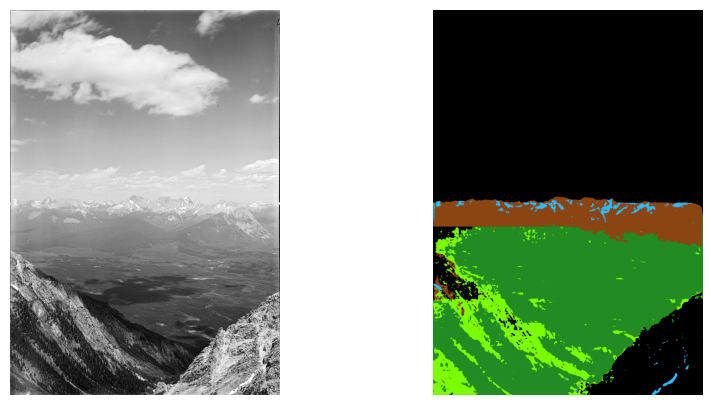

In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_side_by_side(image1_path, image2_path):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Load and display the first image in grayscale
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    axes[0].imshow(img1, cmap='gray')
    axes[0].axis('off')

    # Load and display the second image
    img2 = mpimg.imread(image2_path)
    axes[1].imshow(img2)
    axes[1].axis('off')

    plt.show()


image = '/content/gdrive/MyDrive/pylc/historic-test-images/hi-0027.tif'
mask = '/content/pylc/data/outputs/pylc_deeplab_ch1_schema_a/masks/hi-0027_tif_scale_1.0.png'


display_side_by_side(image, mask)